# Importing required libraries::

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Reading csv file of wholesale customers data set::
  This file is taken from the link provided in the project2 pdf containing 440 rows

In [90]:
wholesale_customers_data = pd.read_csv("./data/wholesale_customers_data.csv")
wholesale_customers_data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# Phase exploring data analysis(EDA)::

In [91]:
wholesale_customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


- All the columns are numerical columns.

In [92]:
wholesale_customers_data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [93]:
wholesale_customers_data.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

- Checking if the rows contains any null values. It doesn't contain any null values otherwise we should go for adjusting the values.

In [94]:
channelUniqueValues = wholesale_customers_data['Channel'].unique()
regionUniqueValues = wholesale_customers_data['Region'].unique()
print(f"channelUniqueValues {channelUniqueValues}, regionUniqueValues {regionUniqueValues}")

channelUniqueValues [2 1], regionUniqueValues [3 1 2]


-  column channel has two unique value 1 and 2, which can be considered 2 categories, similarly region has also three unique values, i.e. we have region and channel as categorical features, and other columns are numerical features.

# Plotting correlation heatmap to see the relation between features::

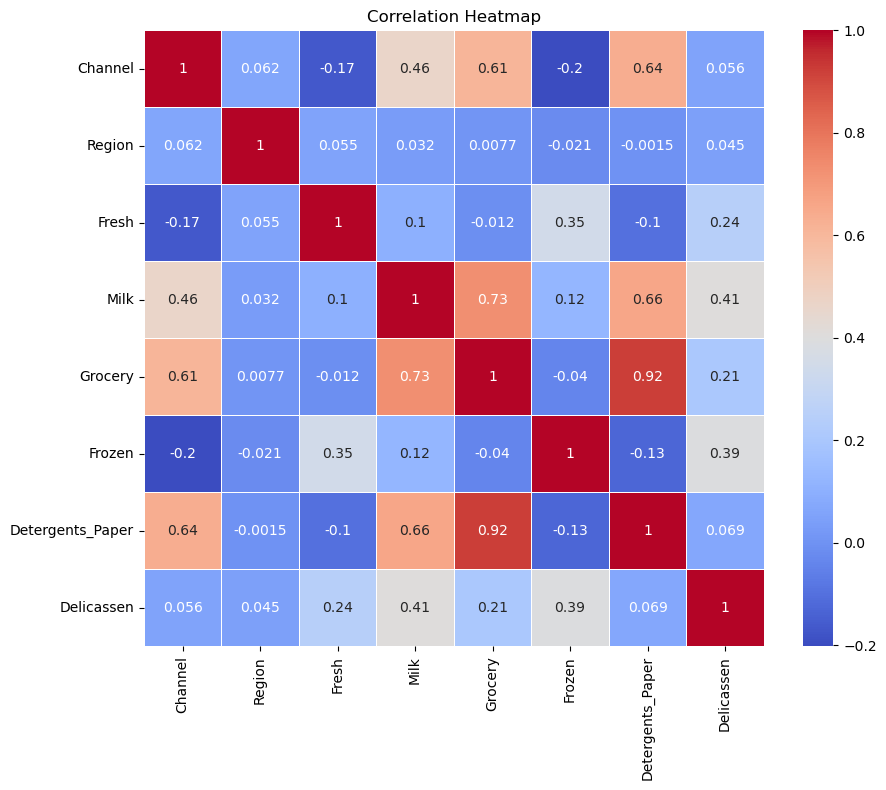

In [95]:
corr_matrix = wholesale_customers_data.corr()

plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title('Correlation Heatmap')
plt.show()

- verifying the correlation heatmap, we can see Grocery is highly positive correlated with the Detergents_paper and Milk. Detergents_paper and Milk are also related. so, we can remove the two features keeping Grocery only. We will keep other even if the impact is less.

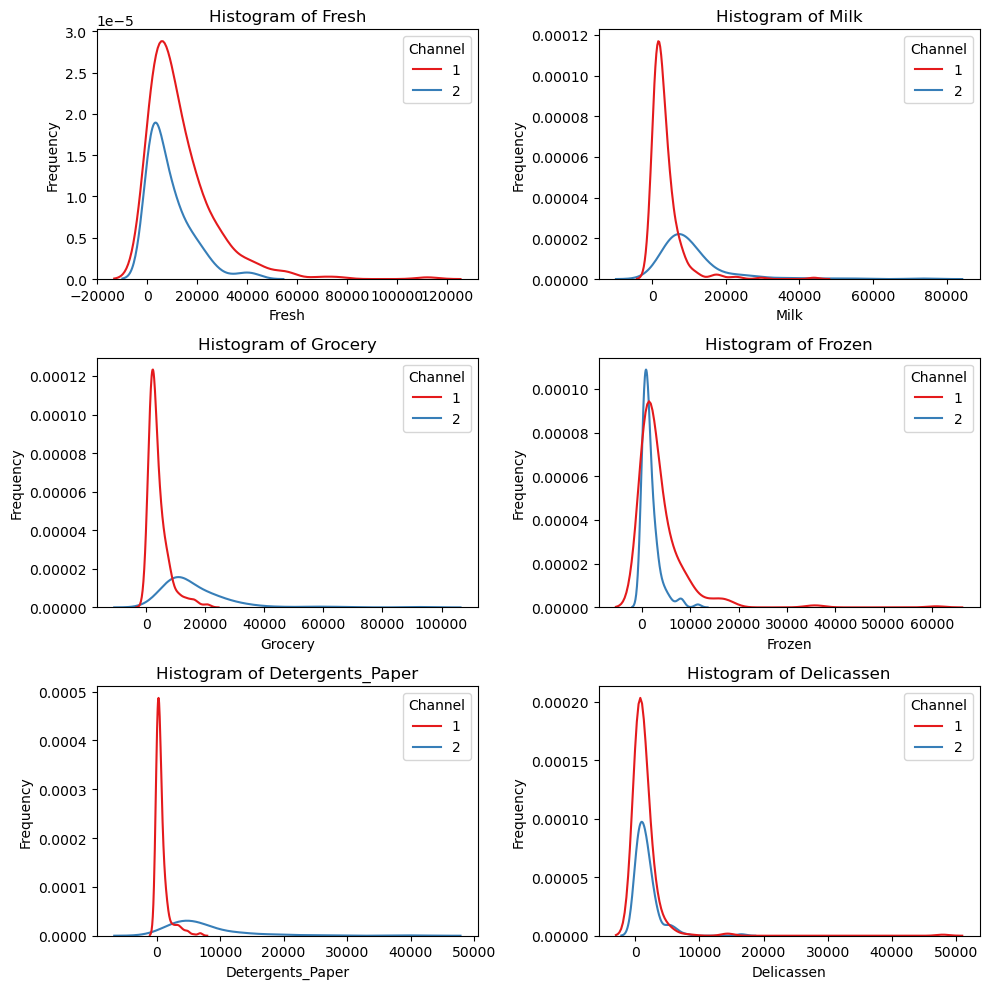

In [96]:
plt.figure(figsize=(10, 10))
for index, feature in enumerate(["Fresh","Milk","Grocery","Frozen","Detergents_Paper","Delicassen"]):
    plt.subplot(3, 2, index+1)
    sns.kdeplot(data=wholesale_customers_data, x=feature, hue='Channel', palette='Set1')
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Our all continuous features follows a normal distribution. But the features selection are quite hard from this plot as we can see lots of overlap on all the features to predict channel.

# Implement Feature Scaling to Normalize the data::

In [97]:
#Implementing feature scaling using minMaxScaler
scaler = MinMaxScaler()
minMaxScaledWCD = scaler.fit_transform(wholesale_customers_data)
minMaxScaledwholesale_customers_data = pd.DataFrame(minMaxScaledWCD, columns=wholesale_customers_data.columns)

#Implementing feature scaling using standardscaler
scaler = StandardScaler()
standardScaledWCD = scaler.fit_transform(wholesale_customers_data)
standardScaledwholesale_customers_data = pd.DataFrame(standardScaledWCD, columns=wholesale_customers_data.columns)

In [98]:
minMaxScaledwholesale_customers_data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.322727,0.771591,0.106977,0.078173,0.085671,0.050078,0.070510,0.031745
std,0.468052,0.387136,0.112774,0.100491,0.102430,0.079789,0.116790,0.058826
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.027863,0.020124,0.023174,0.011788,0.006216,0.008453
50%,0.000000,1.000000,0.075802,0.048636,0.051225,0.024670,0.019927,0.020077
75%,1.000000,1.000000,0.150968,0.097154,0.114821,0.058005,0.095997,0.037907
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [99]:
standardScaledwholesale_customers_data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,4.400000e+02,4.400000e+02,4.400000e+02,440.000000,4.400000e+02,4.400000e+02,4.400000e+02,4.400000e+02
mean,1.614870e-17,3.552714e-16,-3.431598e-17,0.000000,-4.037175e-17,3.633457e-17,2.422305e-17,-8.074349e-18
std,1.001138e+00,1.001138e+00,1.001138e+00,1.001138,1.001138e+00,1.001138e+00,1.001138e+00,1.001138e+00
min,-6.902971e-01,-1.995342e+00,-9.496831e-01,-0.778795,-8.373344e-01,-6.283430e-01,-6.044165e-01,-5.402644e-01
25%,-6.902971e-01,-7.023369e-01,-7.023339e-01,-0.578306,-6.108364e-01,-4.804306e-01,-5.511349e-01,-3.964005e-01
50%,-6.902971e-01,5.906683e-01,-2.767602e-01,-0.294258,-3.366684e-01,-3.188045e-01,-4.336004e-01,-1.985766e-01
75%,1.448652e+00,5.906683e-01,3.905226e-01,0.189092,2.849105e-01,9.946441e-02,2.184822e-01,1.048598e-01
max,1.448652e+00,5.906683e-01,7.927738e+00,9.183650,8.936528e+00,1.191900e+01,7.967672e+00,1.647845e+01


In [100]:
#Plot function for histogram with kde
plt.figure(figsize=(15, 10))
def histKdePlot(data, type):
        sns.histplot(data, kde=True)
        plt.title(f'{type} histogram with KDE')
        return plt

<Figure size 1500x1000 with 0 Axes>

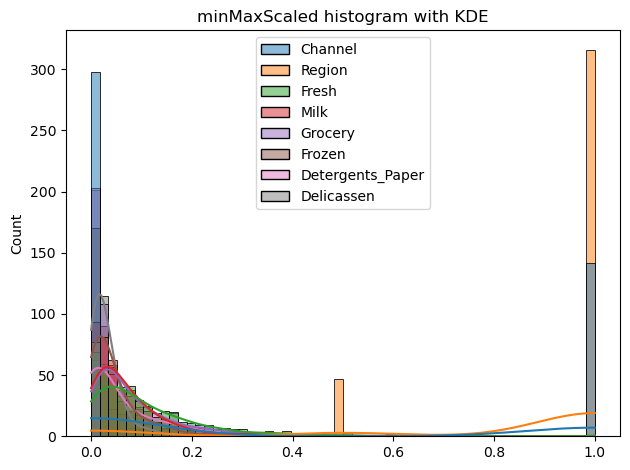

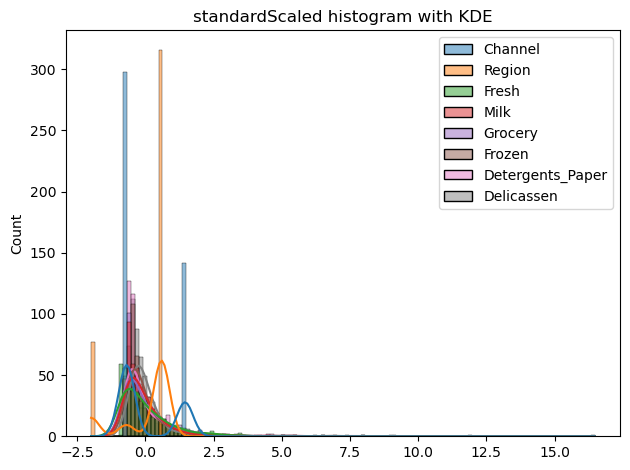

In [101]:
plt = histKdePlot(minMaxScaledwholesale_customers_data, "minMaxScaled")
plt.tight_layout()
plt.show()

plt = histKdePlot(standardScaledwholesale_customers_data, "standardScaled")
plt.tight_layout()
plt.show()

- As we can see from the above graphs, the minmax scaler has decreased the distribution to fit on the values between to 0 and 1 whilst the standard scaler tries to maintain the originality of the data by trasforming so as to make mean =0 and standard deviation = 1. we haven't checked and handled outliers, so using standard scaler will work well with outliers while the minmax is sensitive to the outliers. Also we checked the kde above all of our numerical fetaures follows a normal distibution, standard scalar will work fine with it whereas minmax works fine with non-normal distribution. Also we will be using principal component analysis (PCA) or k-means clustering which are sensitive to the scale of data. so, its better to use standardScaler.

## Find optimal number of features using RFECV and show the plot between Number of features selected vs Cross validation score:::

In [102]:
le = LabelEncoder()
standardScaledwholesale_customers_data['Channel'] = le.fit_transform(wholesale_customers_data['Channel'])

In [103]:
#Taking channel as the target
target = standardScaledwholesale_customers_data['Channel']
features = standardScaledwholesale_customers_data.drop(["Channel"], axis=1)

features.head()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.590668,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,0.590668,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,0.590668,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,0.590668,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,0.590668,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347


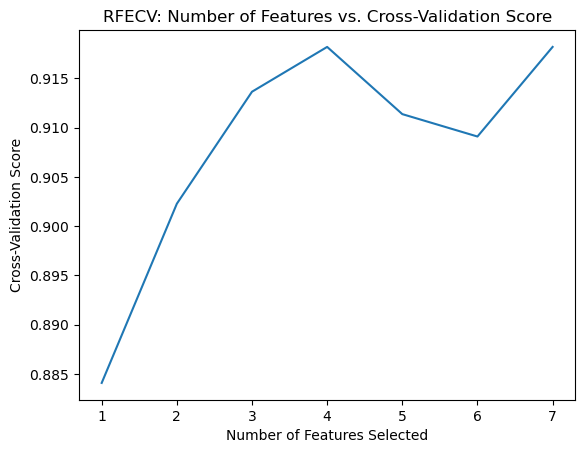

Optimal number of features: 4
Selected features: [False  True  True  True False  True False]


In [104]:
rfModel = RandomForestClassifier(n_estimators=10, random_state=0)

rfecv = RFECV(rfModel, cv= StratifiedKFold(n_splits=5), scoring='accuracy')

rfecv.fit(features, target)

optimalNumberOfFeatures = rfecv.n_features_

featuresSelected = rfecv.support_



plt.figure()
plt.title('RFECV: Number of Features vs. Cross-Validation Score')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation Score')
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

print(f"Optimal number of features: {optimalNumberOfFeatures}")
print(f"Selected features: {featuresSelected}")

- From the graph we can analyze that, we are getting highest result when we use 4 features and even similar result when used 7 features. but when used 5 or 6 features the cv score is showing significant decrease on the score. The features selected for predicting Channel are Milk, Groceries, Fresh and Detergents_Paper.

# Using elbowplot to determine the optimal number of clusters:::

In [105]:
def calculateKmeans(n_clusters,data):
    kmeans = KMeans(n_clusters, random_state=42, n_init=10).fit(data)
    return kmeans

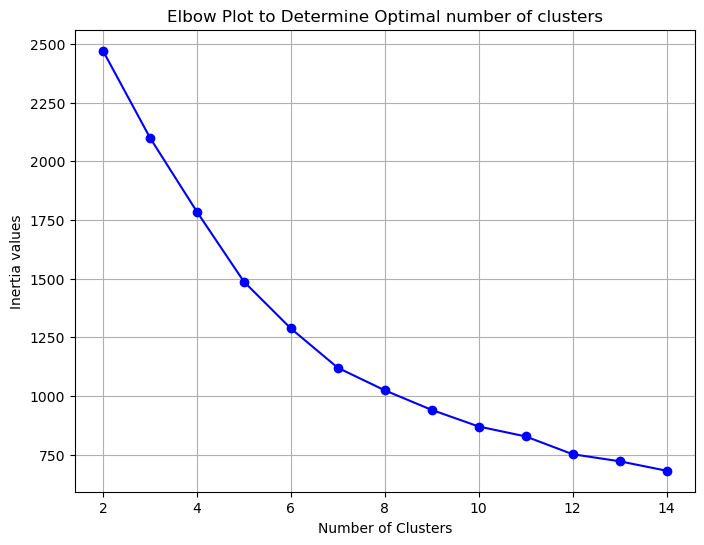

In [106]:
numberOfClusters = range(2, 15)
kmeansInertiaValues = []

for k in numberOfClusters:
    kmeans = calculateKmeans(k, standardScaledwholesale_customers_data)
    kmeansInertiaValues.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(numberOfClusters, kmeansInertiaValues, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia values')
plt.title('Elbow Plot to Determine Optimal number of clusters')
plt.grid(True)
plt.show()


- The figure shows elbow point breaks at 5 or can say at 7, so we will take the number of optimal clusters as 5.

In [107]:
optimalClusters = 5

# Implementing kmeans clustering and PCA:::

In [108]:
# Implementing the kmeans clurstering for the features using the optimal value:
kmeansOptimal = calculateKmeans(optimalClusters, standardScaledwholesale_customers_data)
optimalClusterslabels = kmeansOptimal.labels_
optimalCLustersCenters = kmeansOptimal.cluster_centers_
print(optimalClusterslabels)
print(optimalCLustersCenters)

[0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 2 0 1 1 1 0 1 1 1 1 1 1 0 1
 0 0 1 1 1 0 0 0 0 0 2 0 0 1 1 1 0 1 1 2 0 1 1 1 2 1 0 1 2 1 0 1 1 1 0 1 1
 1 1 1 0 1 1 1 0 0 1 1 2 2 1 1 1 1 1 2 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 2 0 4 1
 1 1 1 0 0 1 1 1 0 1 1 3 3 3 3 0 0 3 3 3 0 3 3 3 0 3 2 3 3 3 3 0 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 0 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 3 3
 3 3 0 3 3 0 0 0 0 0 0 3 3 0 3 3 0 3 3 0 3 3 3 0 3 3 3 3 3 4 3 3 3 3 3 0 3
 2 3 3 3 3 3 3 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1]
[[ 0.94897959  0.26082002 -0.45304124  0.58230088  0.84907491 -0.34638555
   0.86722874  0.05975486]
 [ 0.1

In [109]:
# Implementing PCA:
def implementPCA(n_components, data):
    pca = PCA(n_components)
    pca.fit(data)
    return pca

pca = implementPCA(standardScaledwholesale_customers_data.shape[1], standardScaledwholesale_customers_data)
pcaFeatures = pca.transform(standardScaledwholesale_customers_data)

print(pcaFeatures)

[[ 0.33202586 -0.33116137 -0.69254394 ...  0.44030184 -0.61044145
   0.04008918]
 [ 0.56969637 -0.34389735 -0.6065623  ...  0.31411976 -0.55115758
   0.09785514]
 [ 0.90642417  0.80779591 -0.56140701 ... -0.43065368 -0.56535928
  -0.23305856]
 ...
 [ 3.57400889 -0.89943624 -0.60705744 ... -0.53294965  0.1036548
  -0.09174725]
 [-0.94563662 -0.00805704 -0.64275544 ... -0.08367806  0.19082036
  -0.04424239]
 [-1.10434554 -0.84222897 -0.63594643 ...  0.12320181  0.23836311
   0.00993118]]


# Calculating variance explained by first 2 components and by first 4 components in PCA and visualizing the clusters in the data using PCA:::

In [110]:
# calculating variance explained by the first 2 components:::
explainedVarianceForFirst2 = pca.explained_variance_[:2]
explainedVarianceRatioForFirst2 = pca.explained_variance_ratio_[:2]
print(f"Explained Variance by the First 2 Components: {explainedVarianceForFirst2}")
print(f"Explained Variance Ratio by the First 2 Components: {explainedVarianceRatioForFirst2}")


# calculating variance explained by the first 4 components:::
explainedVarianceForFirst4 = pca.explained_variance_[:4]
explainedVarianceRatioForFirst4 = pca.explained_variance_ratio_[:4]
print(f"Explained Variance by the First 4 Components: {explainedVarianceForFirst4}")
print(f"Explained Variance Ratio by the First 4 Components: {explainedVarianceRatioForFirst4}")


Explained Variance by the First 2 Components: [2.7316186  1.72877276]
Explained Variance Ratio by the First 2 Components: [0.37755521 0.2389452 ]
Explained Variance by the First 4 Components: [2.7316186  1.72877276 1.0095702  0.73977688]
Explained Variance Ratio by the First 4 Components: [0.37755521 0.2389452  0.13953943 0.10224949]


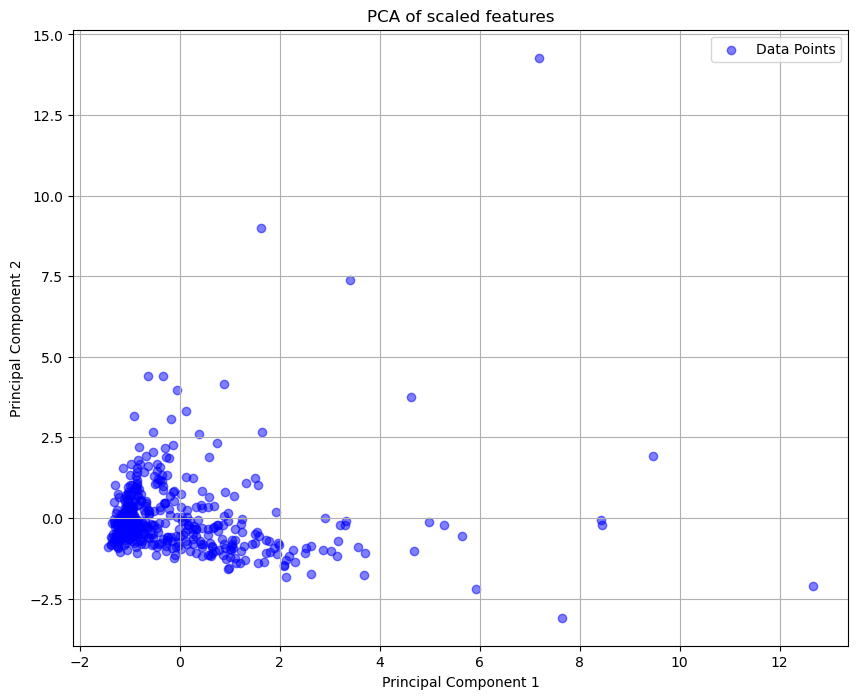

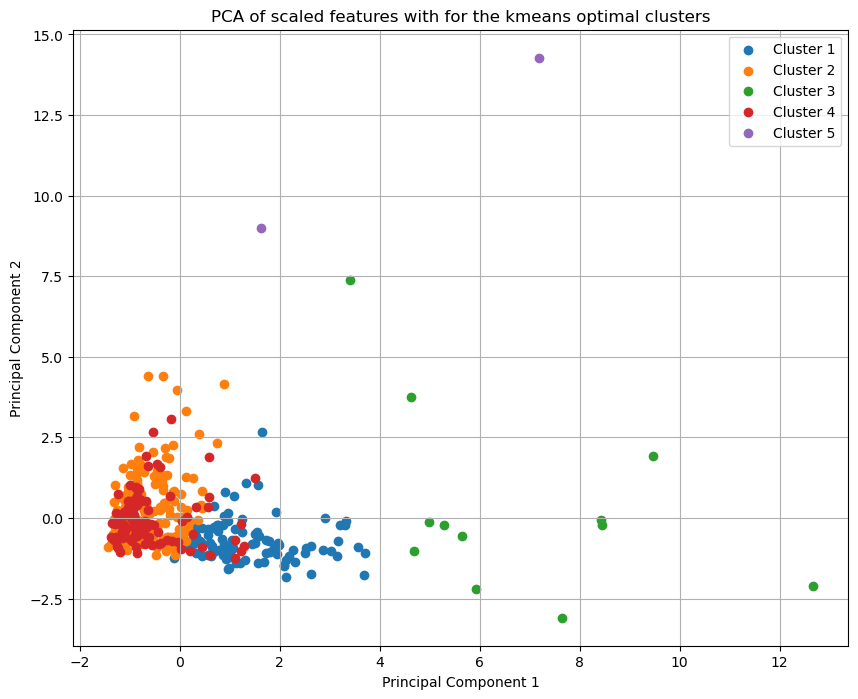

In [111]:
# Visualize the data points in the PCA space
plt.figure(figsize=(10, 8))
plt.scatter(pcaFeatures[:, 0], pcaFeatures[:, 1], c='blue', alpha=0.5, label='Data Points')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of scaled features")
plt.grid(True)
plt.legend()
plt.show()

#visualization of optimal clustering with the PCA
plt.figure(figsize=(10, 8))
plt.title("PCA of scaled features with for the kmeans optimal clusters")
for i in range(5):
    # using optimalCLusterslabels from kmeans calculated above
    plt.scatter(pcaFeatures[optimalClusterslabels == i, 0], pcaFeatures[optimalClusterslabels == i, 1], label=f'Cluster {i+1}')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend()
plt.show()


- Here we have done the scatter plot for the principal component 1 and 2 which are the components with the highest and second highest variance. Using the PCA we have reduced the dimension for analysis. We can also see how the distribution of the PCA data looks on each optimal clusters given by the kmeans. we can analyze the underlying data structure using this simplified dimension easily.

# Implement XGBoost Classifier with 5 Fold CV and report the performance metrics:::

In [112]:
# splitting the dataset into 80 20 ratio
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [118]:
xgbcModel = XGBClassifier()
cv_scores = cross_val_score(xgbcModel, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores}")

xgbcModel.fit(X_train, y_train)

y_pred = xgbcModel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Test Set Accuracy: {:.2f}".format(accuracy))
print("Test Set Precision: {:.2f}".format(precision))
print("Test Set Recall: {:.2f}".format(recall))

Cross-Validation Accuracy: [0.95774648 0.91549296 0.92857143 0.9        0.94285714]
Test Set Accuracy: 0.92
Test Set Precision: 0.81
Test Set Recall: 0.91


- From the XGBoost classifier model, we splitted the data to 80 20 ratio for training and the test purpose. We trainned our model and did cross fold validation for 5 fold and got minimum 90% of accurate prediction. Further, we did predict on the test dataset, for which we got 92% accuracy , 81% precision and 91% recall.